In [212]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque
import random
from tqdm import tqdm

try:
    import gym
except ImportError:
    %pip install gym
    import gym


In [213]:
# plotting settings and device

sns.set_theme(style='whitegrid')
color_palette = plt.cm.tab10.colors
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # else gives error when trying to plot
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Define Environment by Gymnasium

[Environment Details](https://gymnasium.farama.org/environments/classic_control/mountain_car/)

Full Example on Github of the [Mountain Car](https://github.com/guillaumefrd/q-learning-mountain-car)

In [214]:
env = gym.make('MountainCar-v0', render_mode='human')

In [215]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Number of actions available: 3
Observation shape: (2,)


#### <span style="text-decoration:underline;">Explanations:</span>
- Observation space:
    - [-1.2 0.6] position range (in m)
    - [-0.07 0.07] velocity range (in v = m/s)
    - 2dim phase space (x-v-space)
- Actions:
    - 0: Accelerate to left
    - 1: Don't accelerate
    - 2: Accelerate to right
### <span style="text-decoration:underline;">Transition dynamics:</span>
<span style="text-decoration:underline;">Variables:</span>

Force $F$, action $a$, position $x$, velocity $v$, time (discrete) $t$, gravity $g$

The transition dynamics then reads:
$$
\begin{align}
v_{t+1} &= v_t + (a - 1)F - \cos(3x_t)g\\ 
x_{t+1} &= x_t + v_{t+1}
\end{align}
$$

Physical explanation:
- $ (a - 1) \implies$: -1: left, 0; no acceleration; +1: right acceleration; magnitude $F$
- Physically, the dimensions are an acceleration (setting $m=1$ and having a force balance of $\Delta v = v_{t+1}-v_t$)
- The last term is gravitational force, where the angle is expressed as $\alpha=3x$

#### <span style="text-decoration:underline;">Notes</span>
- The default reward setting is -1 per time step
- Environment acts stochastically, start position is in a fixed range

#### Define the general functions

### Plotting Functions

In [216]:
# Plotting functions

def plot_mean_reward_per_episode(reward_dict, ax=None):
    """
    reward_dict: dictionary containing the rewards per episode, optionally add environment and auxiliary rewards
    class_name: name of the class
    save_name: name to save the plot
    """
    if ax is None:
        _, ax = plt.subplots()
    window_size = 25
    for key in reward_dict:
        moving_avg = np.convolve(reward_dict[key], np.ones(window_size) / window_size, mode='valid')
        moving_CI = np.std(
            [reward_dict[key][i:i + window_size] for i in range(len(reward_dict[key]) - window_size + 1)], axis=1) / np.sqrt(window_size) * 1.96

        ax.plot(moving_avg, label=f'{key}'.replace("episodes_", ""))
        ax.fill_between(np.arange(len(moving_avg)), moving_avg - moving_CI, moving_avg + moving_CI, alpha=0.2)
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Average rewards per episode')
    #if len(reward_dict) > 1:
    #    ax.legend()  # --> remove as it is plotted for cumulative reward already, looks better


def plot_cumulative_rewards(reward_dict, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    for key in reward_dict:
        cum_rewards = np.cumsum(reward_dict[key])
        ax.plot(cum_rewards, label=f'{key}'.replace("episodes_", ""))
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Cumulative rewards up to episode n')
    if len(reward_dict) > 1:
        ax.legend()


def plot_training_loss(loss_dict, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    window_size = 250
    for key in loss_dict:
        moving_avg = np.convolve(loss_dict[key], np.ones(window_size) / window_size, mode='valid')
        moving_CI = np.std(
            [loss_dict[key][i:i + window_size] for i in range(len(loss_dict[key]) - window_size + 1)], axis=1) / np.sqrt(window_size) * 1.96

        ax.plot(moving_avg, label=f'{key}'.replace("training_", ""))
        ax.fill_between(np.arange(len(moving_avg)), moving_avg - moving_CI, moving_avg + moving_CI, alpha=0.2)
    ax.set_xlabel('Steps')
    ax.set_ylabel('MSE per step')
    if len(loss_dict) > 1:
        ax.legend() 


def plot_success(training_stats, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(training_stats['cumulative_successes'])
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative number of successes')

def plot_episode_duration(training_stats, ax=None):
    episodes = np.arange(len(training_stats['episodes_lengths']))
    if ax is None:
        _, ax = plt.subplots()
    ax.scatter(episodes, training_stats['episodes_lengths'], alpha=0.8, s=0.75)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Steps taken')

# Create list of possible keys for rewards
reward_keys = ['episodes_rewards', 'episodes_environment_rewards', 'episodes_auxiliary_rewards']
loss_keys = ['training_batch_loss', 'training_rnd_loss']

## Define a Run function to run the Agent 

In [217]:
def run(agent, episodes, max_episode_steps=None, render=False):
    """
    Run the Agent through the environment
    :param agent: the agent to run on the environment
    :param episodes: number of episodes to run the algorithm
    :param max_episode_steps: maximum number of steps in an episode
    :param render: boolean to render the environment or not
    :return: training_stats: dictionary containing the training statistics:
        - episodes_lengths: the length of each episode
        - episodes_mean_batch_loss: the mean batch loss of each episode
        - episodes_mean_rnd_loss: the mean rnd loss of each episode (only for DQN + RND)
        - episodes_environment_rewards: the environment reward of each episode
        - episodes_auxiliary_rewards: the auxiliary reward of each episode
        - episodes_rewards: the total reward of each episode
        - cumulative_successes: the cumulative number of episodes that reached the goal
        - training_batch_loss: the batch loss at each step
        - training_rnd_loss: the rnd loss at each step (DQN + RND only)
    """

    # load the environment
    env = gym.make('MountainCar-v0', render_mode='human' if render else None)

    # episodes stats
    episodes_lengths = []
    episodes_mean_batch_loss = []
    episodes_mean_rnd_loss = []
    episodes_environment_rewards = []
    episodes_auxiliary_rewards = []
    episodes_rewards = []
    cumulative_successes = [0]

    # track steps and loss at each step
    total_steps = 0
    training_batch_loss = []
    training_rnd_loss = []

    for _ in tqdm(range(episodes)):
        # reset episode and episode's statistics
        state, _ = env.reset()
        episode_environment_reward = 0.0
        episode_auxiliary_reward = 0.0
        episode_reward = 0.0
        episode_batch_loss = 0.0
        episode_rnd_loss = 0.0

        terminated = False
        truncated = False
        episode_steps = 0

        while not terminated and (not truncated if not max_episode_steps else episode_steps < max_episode_steps):
            # select and take action based on agent's policy
            action = agent.select_action(state)
            next_state, environment_reward, terminated, truncated, _ = env.step(action)

            # Observe transition
            auxiliary_reward = agent.observe(state, action, next_state, environment_reward, terminated)

            # update the agent and get the loss 
            batch_loss, rnd_loss = agent.update()

            # update state
            state = next_state

            # Store the rewards and loss for the episode's stats
            episode_environment_reward += environment_reward
            episode_auxiliary_reward += auxiliary_reward
            episode_reward += environment_reward + auxiliary_reward
            episode_batch_loss += batch_loss
            episode_rnd_loss += rnd_loss

            # Store the loss for this step
            training_batch_loss.append(batch_loss)
            training_rnd_loss.append(rnd_loss)

            # Increase the steps counters
            episode_steps += 1
            total_steps += 1

        # save the best policy network
        if not episodes_environment_rewards or episode_environment_reward <= max(episodes_environment_rewards):
            agent.save()

        # Record cumulative successes
        cumulative_successes.append(cumulative_successes[-1])
        if terminated:
            cumulative_successes[-1] += 1

        # store the training statistics
        episodes_mean_rnd_loss.append(episode_rnd_loss / episode_steps)
        episodes_lengths.append(episode_steps)
        episodes_mean_batch_loss.append(episode_batch_loss / episode_steps)
        episodes_environment_rewards.append(episode_environment_reward)
        episodes_auxiliary_rewards.append(episode_auxiliary_reward)
        episodes_rewards.append(episode_reward)

        # decay epsilon
        agent.decay_epsilon()

    env.close()

    # remove the first element of cumulative_successes as it was only initisalised to iterate
    cumulative_successes.pop(0)

    training_stats = {
        "episodes_lengths": episodes_lengths,
        "episodes_mean_batch_loss": episodes_mean_batch_loss,
        "episodes_mean_rnd_loss": episodes_mean_rnd_loss,
        "episodes_environment_rewards": episodes_environment_rewards,
        "episodes_auxiliary_rewards": episodes_auxiliary_rewards,
        "episodes_rewards": episodes_rewards,
        "cumulative_successes": cumulative_successes,
        "training_batch_loss": training_batch_loss,
        "training_rnd_loss": training_rnd_loss
    }

    return training_stats

## Define NN class, to initialise for DQN with tunable hidden layers and neuron number

In [218]:
class DQN(nn.Module):
    def __init__(self, input_states, out_actions, hidden_layers=2, hidden_nodes=64):
        super(DQN, self).__init__()

        self.hidden_layers = nn.ModuleList([nn.Linear(input_states, hidden_nodes)])
        self.hidden_layers.extend([nn.Linear(hidden_nodes, hidden_nodes) for _ in range(hidden_layers - 1)])
        self.out = nn.Linear(hidden_nodes, out_actions)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = F.relu(layer(x)) # use ReLU activation function
        x = self.out(x)
        return x

## First steps --> Random Agent
- Initialise a random Agent to take random movements
- save duration for each episode -> reward count can be used for this

In [219]:
class RandomAgent:
    def __init__(self):
        self.action_space = env.action_space
        self.observation_space = env.observation_space

    def observe(self, state, action, next_state, reward, terminated):
        return 0

    def select_action(self, state):
        return self.action_space.sample()  # take a random action

    def update(self):
        return 0, 0  # return 0 for loss to avoid error

    def save(self):
        pass

    def decay_epsilon(self):
        pass

#### Run the random agent for an episode and render it

In [220]:
random_agent = RandomAgent()
_ = run(random_agent, 1, render=True)

  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Lione\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1/1 [00:07<00:00,  7.61s/it]


#### Run the random Agent 100 times and plot the lengths of the episodes for different max lengths.

100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


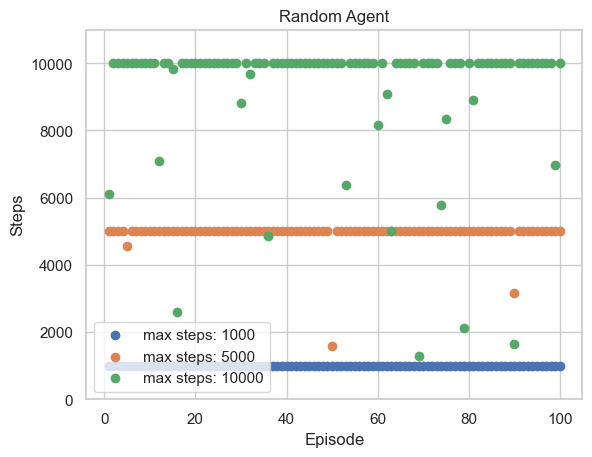

In [221]:
# run the random Agent 100 times and plot rewards
random_agent = RandomAgent()
max_episode_lengths = [1000, 5000, 10000]
episode_lengths = []  # why need this list? Cannot just use reward, and we can see if the agent reaches the top in the graph below

fig, ax = plt.subplots()

for max_episode_length in max_episode_lengths:
    training_stats = run(random_agent, 100, max_episode_steps=max_episode_length)
    episode_lengths.append(training_stats['episodes_lengths'])

    # plot steps taken of current episode
    ax.scatter(np.arange(1, 101), training_stats['episodes_lengths'], label=f'max steps: {max_episode_length}')

#ax.hlines(np.abs(5000), 0, 100, colors='red', linestyles='dashed', label='threshold') --> In case we want to plot a threshold line
ax.set(xlabel='Episode', ylabel='Steps', title='Random Agent', ylim=(0, 11000))

plt.legend(loc='lower left')
plt.savefig('figures/Random_Agent_varyin.png')
plt.show()

## Define basic DQN Agent with optional use of heuristic auxiliary reward

In [222]:
class DQNAgent:
    def __init__(self, save_name: str, trainable: bool, use_domain_reward=False, domain_reward_factor=1.0, gamma=0.99,
                 epsilon=0.9, epsilon_decay=0.99, epsilon_min=0.05,
                 batch_size=64, learning_rate=0.001, sync_rate=1000, optimizer=optim.AdamW):
        # Initialize agent
        self.save_name = save_name
        self.trainable = trainable
        self.use_domain_reward = use_domain_reward
        self.domain_reward_factor = domain_reward_factor
        self.action_space = env.action_space
        self.replay_buffer = deque([], maxlen=10000)  # replay buffer with fixed size of 10000
        self.epsilon = epsilon  # exploration rate
        self.epsilon_decay = epsilon_decay  # 0.99 -> reach minimum after >~ 300 episodes
        self.epsilon_min = epsilon_min  # minimum value of epsilon
        self.gamma = gamma  # discount factor
        self.batch_size = batch_size  # batch size for training
        self.sync_rate = sync_rate  # rate at which to sync target network with policy network  
        self.loss = nn.MSELoss()  # loss function 
        self.steps = 0

        # Initialize Q-networks separately otherwise we update both networks 
        self.policy_net = DQN(input_states=env.observation_space.shape[0], out_actions=self.action_space.n,
                              hidden_layers=2, hidden_nodes=64).to(device)
        self.target_net = DQN(input_states=env.observation_space.shape[0], out_actions=self.action_space.n,
                              hidden_layers=2, hidden_nodes=64).to(device)
        if not trainable:  # load the best network 
            self.policy_net.load_state_dict(torch.load(f'trained_models/{self.__class__.__name__}_{save_name}.pth'))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optimizer(self.policy_net.parameters(), lr=learning_rate)

        # Track loss
        self.losses = []

    def observe(self, state, action, next_state, reward, terminated):
        # Increment the agent's steps count
        self.steps += 1

        # Use auxiliary reward if necessary
        auxiliary_reward = self.domain_based_reward(next_state) if self.use_domain_reward else 0.0
        reward += auxiliary_reward * self.domain_reward_factor

        # Update agent's internal memory with observed transition
        self.replay_buffer.append((state, action, next_state, reward, terminated))

        return auxiliary_reward

    def select_action(self, state):
        # Select action based on epsilon-greedy policy -> returns action

        if np.random.rand() < self.epsilon and self.trainable:
            action = self.action_space.sample()
        else:
            with torch.no_grad():  # no need to calculate gradients
                state_tensor = torch.tensor(state, device=device)
                action = torch.argmax(
                    self.policy_net(state_tensor)).item()  # exploit with probability 1-epsilon from policy network
        return action

    def update(self):
        # Update agent's policy based on observed transitions
        batch_loss = 0

        # sample mini-batch from memory, don't use for loop
        if len(self.replay_buffer) > self.batch_size and self.trainable:
            mini_batch = random.sample(self.replay_buffer, self.batch_size)

            # unpack mini-batch
            states = torch.tensor([transition[0] for transition in mini_batch], dtype=torch.float, device=device)
            actions = torch.tensor([transition[1] for transition in mini_batch], dtype=torch.long, device=device)
            next_states = torch.tensor([transition[2] for transition in mini_batch], dtype=torch.float, device=device)
            rewards = torch.tensor([transition[3] for transition in mini_batch], dtype=torch.float, device=device)
            terminated = torch.tensor([transition[4] for transition in mini_batch], dtype=torch.bool, device=device)

            with torch.no_grad():
                # calculate target values
                Q_target = torch.zeros(rewards.shape, device=device)
                # solves the issue of terminal states -> target = reward if terminated as Q-value is 0
                Q_target[terminated] = rewards[terminated]
                # note that self.target_net(next_states_tensor[~terminated]).shape = (batch_size, action_space)
                Q_target[~terminated] = rewards[~terminated] + self.gamma * \
                                        torch.max(self.target_net(next_states[~terminated]), dim=1).values

            # calculate the current Q-values
            Q_current = self.policy_net(states)[range(self.batch_size), actions]

            # calculate loss and update policy network
            loss = self.loss(Q_current, Q_target)
            batch_loss = loss.item()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # synchronize the policy and target network
            if self.steps > 0 and self.steps % self.sync_rate:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        # return the loss (batch_loss and no rnd_loss)
        return batch_loss, 0
    
    def decay_epsilon(self):
        # Decay epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def save(self):
        if self.trainable:
            torch.save(self.policy_net.state_dict(),
                       f'trained_models/{self.__class__.__name__}_{self.save_name}.pth')

    # Experiment with different rewards (very high / low)
    def domain_based_reward(self, state):
        """
        Return the position of the car as the reward (between -1.2 and 0.6)
        :param state: the current state of the environment
        :return: the reward
        """
        # reward the total energy, see Transition dynamics for details of equation.
        # Downscale magnitude to ensure goal state yields highest reward still
        # NOTE: potential energy is based on harmonic oscillator
        position = state[0]
        velocity = state[1]
        #return np.abs(position + 0.5) # reward based on distance from start
        return (np.sin(3 * position) + 1) / 4 + (velocity*100/(7)) ** 2 / 2 # total energy, normalised < 1 (both max(0.5))
        #return (np.sin(3 * position) + 1) / 2 # Potential energy only

## Train an agent with DQN without auxiliary function

1. With the normal truncation (200 steps):

In [223]:
# Train the agent with normal truncation
save_name_basic = 'basic'
dqn_agent_normal = DQNAgent(save_name=save_name_basic, trainable=True, use_domain_reward=False)
training_stats = run(dqn_agent_normal, 1000)

100%|██████████| 1000/1000 [06:37<00:00,  2.51it/s]


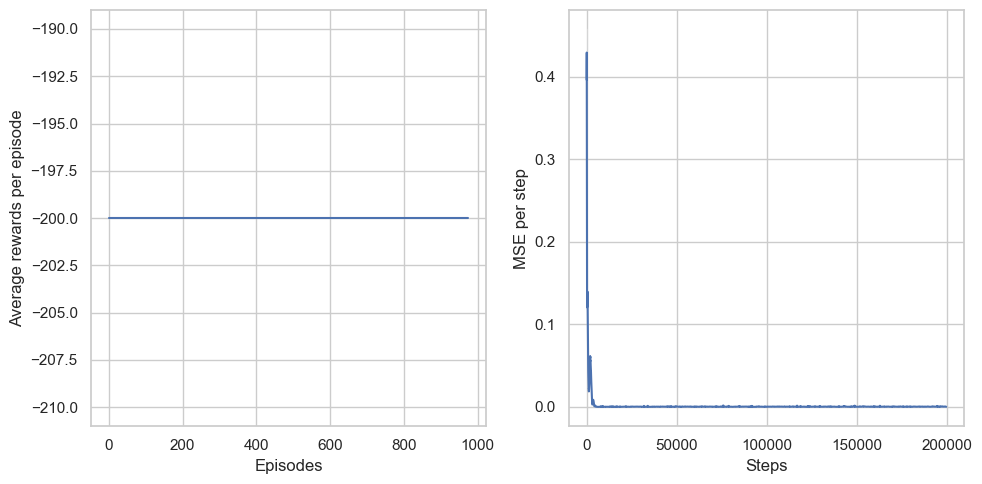

In [224]:
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

reward_dict = {'episodes_environment_rewards': training_stats['episodes_environment_rewards']}
loss_dict = {'training_batch_loss': training_stats['training_batch_loss']}

plot_mean_reward_per_episode(reward_dict, ax=ax1)
plot_training_loss(loss_dict, ax=ax2)

plt.tight_layout()

plt.savefig('figures/DQN_Agent_normal.png')
plt.show()


- The Agent does not solve the problem
- As we never reach the goal and each step yields -1 reward, there is no learning in process as the Q-values will all be equal!

In [225]:
# Render the agent
dqn_agent_render_normal = DQNAgent(save_name=save_name_basic, trainable=False)
_ = run(dqn_agent_render_normal, 1, render=True)

100%|██████████| 1/1 [00:07<00:00,  7.48s/it]


## Train an agent with DQN and heuristically chosen auxiliary reward 
- The chosen reward function is based on the total energy of the system
$$\begin{align*}
E_{tot} 
&= mgz + \dfrac{m}{2}\dot{x}^2\\
&= mg\sin(x) + \dfrac{m}{2}v^2\\
&\propto \alpha \sin(x) + \beta \dot{x}^2
\end{align*}$$
- We rescale in the following manner:
    - $E_{tot}$ must not exceed 1 $\implies$ all possible states should give negative rewards, finding the goal quickly has to remain the primary objective, hence we have to punish each step
    - As there is no given sense of time scale, we rescale the velocity such that maximum velocity at lowest position yields the same reward as highest position at zero velocity (this ensures energy conservation). This should motivate the agent to add energy to the system by accelerating in the right moment
    - Hence the position and velocity terms are restricted to an upper limit of $0.5$ each


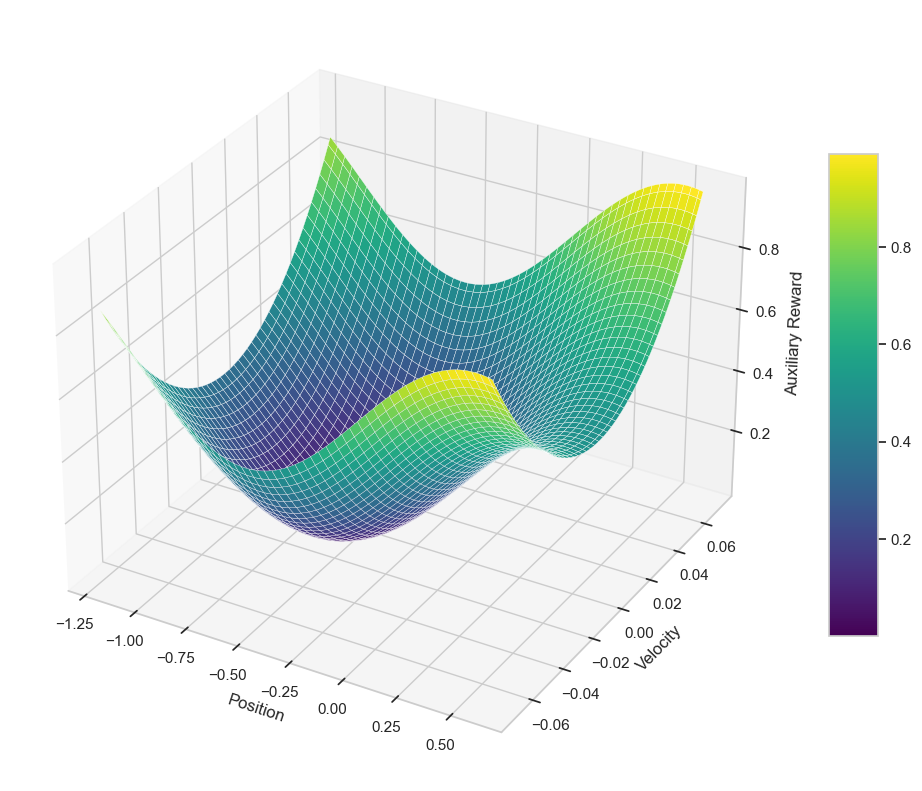

In [226]:
# Displaying the chosen reward function
x = np.linspace(-1.2, 0.6, 100)
y = np.linspace(-0.07, 0.07, 100)
X, Y = np.meshgrid(x, y)
Z = (np.sin(3 * X) + 1) / 4 + (Y*100/(7)) ** 2 / 2

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0.25, label='heuristic reward')
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('Auxiliary Reward')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.savefig('figures/auxiliary_reward_function.png')
plt.show()

In [227]:
# Used to load/save the model
save_name_heuristic = 'heuristic'

dqn_agent_heuristic = DQNAgent(save_name=save_name_heuristic, trainable=True, use_domain_reward=True)
# Train on 3000 episodes (quite long)
heuristic_training_stats = run(dqn_agent_heuristic, 3000)

100%|██████████| 3000/3000 [17:14<00:00,  2.90it/s]


In [228]:
# Render
dqn_agent_render_heuristic = DQNAgent(save_name=save_name_heuristic, trainable=False)
_ = run(dqn_agent_render_heuristic, 1, render=True)

100%|██████████| 1/1 [00:07<00:00,  7.09s/it]


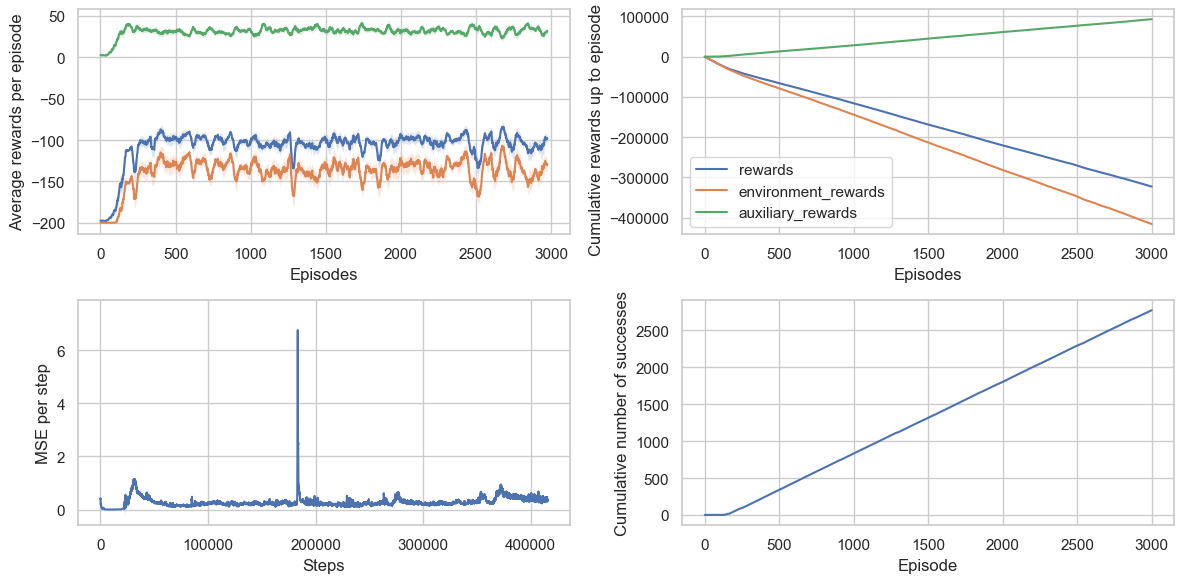

In [229]:
# plot results
heuristic_reward_dict = {key: heuristic_training_stats[key] for key in reward_keys}
heuristic_loss_dict = {'training_batch_loss': heuristic_training_stats['training_batch_loss']}

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

plot_mean_reward_per_episode(heuristic_reward_dict, ax=ax[0][0])
plot_cumulative_rewards(heuristic_reward_dict, ax=ax[0][1])
plot_training_loss(heuristic_loss_dict, ax=ax[1][0])
plot_success(heuristic_training_stats, ax=ax[1][1])

plt.tight_layout()
plt.savefig('figures/DQN_Agent_heuristic.png')
plt.show()

## Heuristic reward with different auxiliary reward scalings

In [230]:
reward_factors = [0, 0.05, 0.1, 0.5, 1, 2.5, 5]
aux_dicts = {}
for reward_factor in reward_factors:
    dqn_agent_aux = DQNAgent(trainable=True, 
                                      save_name=save_name_heuristic, 
                                      use_domain_reward=True, 
                                      domain_reward_factor=reward_factor)
    aux_training_stats = run(dqn_agent_aux, 1000)
    aux_dicts[f'heuristic_training_{reward_factor}'] = aux_training_stats

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]


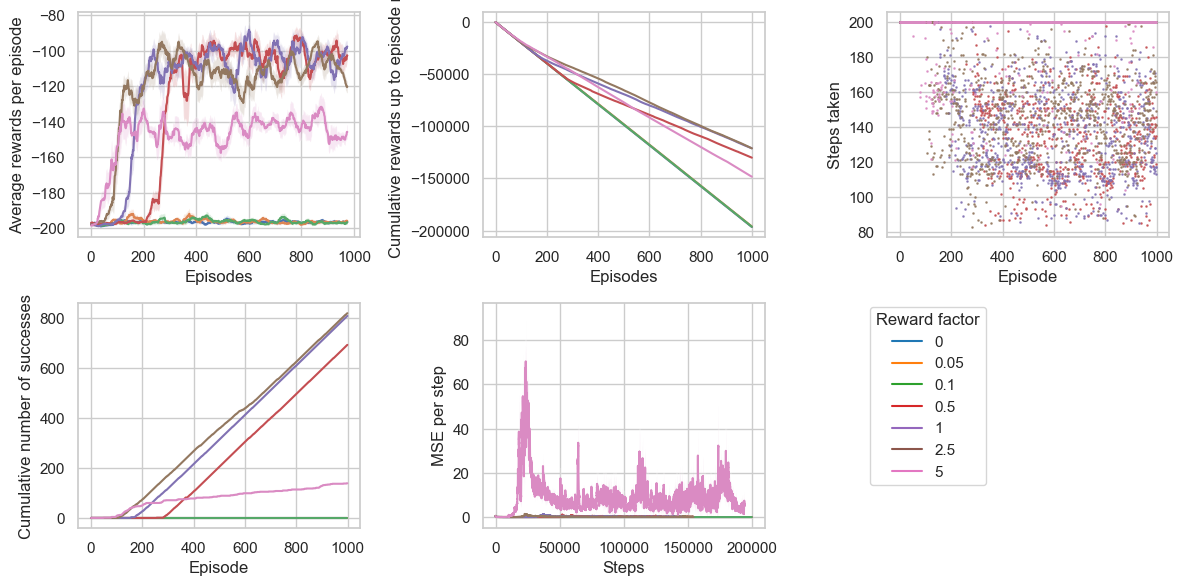

In [231]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

legend_handles = []
for i, reward_factor in enumerate(reward_factors):
    domain_reward_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in reward_keys[0:1]}
    domain_loss_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in loss_keys[0:1]}
    plot_mean_reward_per_episode(domain_reward_dicts, ax=ax[0][0])
    plot_cumulative_rewards(domain_reward_dicts, ax=ax[0][1])
    plot_training_loss(domain_loss_dicts, ax=ax[1][1])
    plot_success(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[1][0])
    plot_episode_duration(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[0][2])
    legend_handles.append(plt.Line2D([0], [0], color=color_palette[i], label=f'{reward_factor}'))
fig.delaxes(ax[1][2])
legend = fig.legend(title='Reward factor', handles=legend_handles, loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/auxiliary_reward_variation.png')

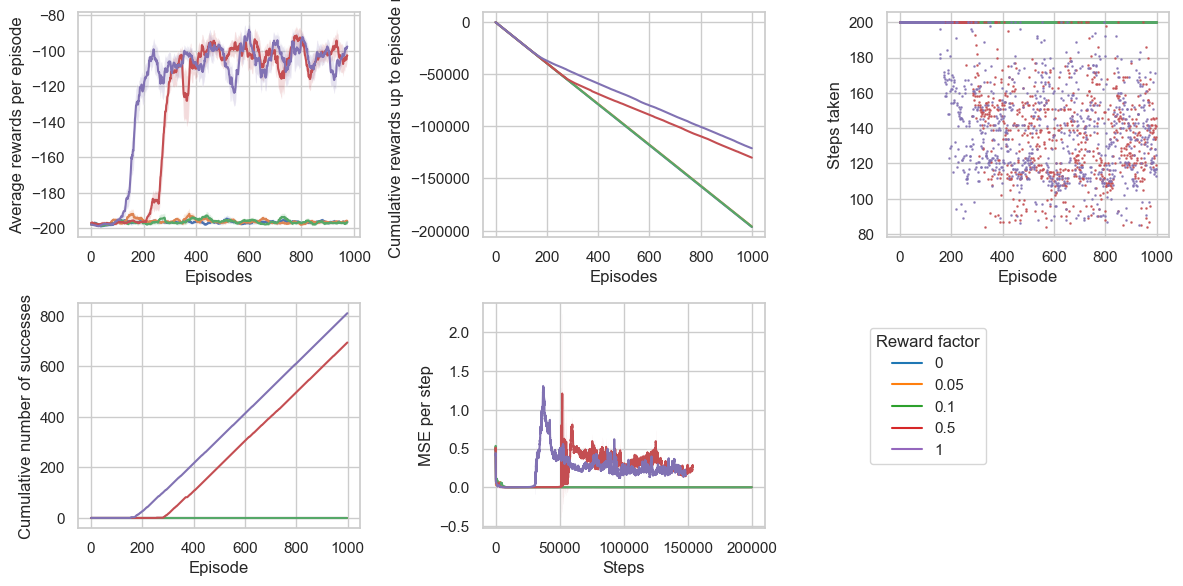

In [232]:
# repeat previous plots without the > 1 reward factors
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

legend_handles = []
for i, reward_factor in enumerate(reward_factors[0:5]):
    domain_reward_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in reward_keys[0:1]}
    domain_loss_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in loss_keys[0:1]}
    plot_mean_reward_per_episode(domain_reward_dicts, ax=ax[0][0])
    plot_cumulative_rewards(domain_reward_dicts, ax=ax[0][1])
    plot_training_loss(domain_loss_dicts, ax=ax[1][1])
    plot_success(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[1][0])
    plot_episode_duration(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[0][2])
    legend_handles.append(plt.Line2D([0], [0], color=color_palette[i], label=f'{reward_factor}'))
fig.delaxes(ax[1][2])
legend = fig.legend(title='Reward factor', handles=legend_handles, loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/auxiliary_reward_variation_below1.png')

## Implementing Random Network Distillation (RND)

In [233]:
# copy previous agent and add changes directly to the class
class DQNAgent_RND:
    def __init__(self, env, trainable: bool, reward_factor=1.0, gamma=0.99, epsilon=0.9, epsilon_decay=0.99,
                 epsilon_min=0.05, batch_size=64, learning_rate=0.001, sync_rate=1000, optimizer=optim.AdamW):
        # Initialize agent
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.trainable = trainable
        self.reward_factor = reward_factor
        self.replay_buffer = deque([], maxlen=10000)  # replay buffer with fixed size of 10000
        self.epsilon = epsilon  # exploration rate
        self.epsilon_decay = epsilon_decay  # decaying rate of epsilon
        self.epsilon_min = epsilon_min  # minimum value of epsilon
        self.gamma = gamma  # discount factor
        self.batch_size = batch_size  # batch size for training
        self.sync_rate = sync_rate  # rate at which to sync target network with policy network  
        self.loss = nn.MSELoss()  # loss function
        self.steps = 0

        # Running estimates of rewards and states stats
        self.states_mean = torch.tensor([0.0] * self.observation_space.shape[0])
        self.states_M2 = torch.tensor(
            [0.0] * self.observation_space.shape[0])  # sum of squared distances from the mean (to compute running std)
        self.rnd_loss_mean = 0.0
        self.rnd_loss_M2 = 0.0  # sum of squared distances from the mean (to compute running std)

        # Initialize Q-networks separately otherwise we update both networks 
        self.policy_net = DQN(input_states=self.observation_space.shape[0], out_actions=self.action_space.n,
                              hidden_layers=2, hidden_nodes=64).to(device)
        self.target_net = DQN(input_states=self.observation_space.shape[0], out_actions=self.action_space.n,
                              hidden_layers=2, hidden_nodes=64).to(device)

        # Additionally initialise predictor and target predictor networks
        self.predictor_net = DQN(input_states=self.observation_space.shape[0], out_actions=1,
                                 hidden_layers=2, hidden_nodes=64).to(device)
        self.target_predictor_net = DQN(input_states=self.observation_space.shape[0], out_actions=1,
                                        hidden_layers=2, hidden_nodes=64).to(device)

        if not trainable:  # load the best network 
            self.policy_net.load_state_dict(torch.load(f'trained_models/{self.__class__.__name__}.pth'))
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.policy_optimizer = optimizer(self.policy_net.parameters(), lr=learning_rate)
        self.predictor_optimizer = optimizer(self.predictor_net.parameters(), lr=learning_rate)

        # Keep track of the loss (computed in observe() but backward in update())
        self.rnd_loss = None

        # Track loss
        self.losses = []

    def observe(self, state, action, next_state, reward, terminated):
        # Increment the agent's steps count
        self.steps += 1

        # Compute the intrinsic reward, store the loss for backward prop. in update()
        rnd_reward, self.rnd_loss = self.compute_rnd_reward(next_state)

        # Update the reward only after a few steps
        rnd_reward = rnd_reward * self.reward_factor if len(self.replay_buffer) > self.batch_size else 0.0
        reward = reward + rnd_reward

        # Update agent's internal memory with observed transition 
        self.replay_buffer.append((state, action, next_state, reward, terminated))

        # Return the intrinsic reward
        return rnd_reward

    def select_action(self, state):
        # Select action based on epsilon-greedy policy -> returns action

        # exponentially decaying epsilon
        exploration_prob = max(self.epsilon * np.exp(-self.steps / self.epsilon_decay), self.epsilon_min)

        if np.random.rand() < exploration_prob and self.trainable:
            action = self.action_space.sample()
        else:
            with torch.no_grad():  # no need to calculate gradients
                state_tensor = torch.tensor(state, device=device)
                action = torch.argmax(
                    self.policy_net(state_tensor)).item()  # exploit with probability 1-epsilon from policy network
        return action
    
    def decay_epsilon(self):
        # Decay epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def update(self):
        # Update the agent  

        # Update the predictor network (we do not do it for the replay buffer: https://arxiv.org/pdf/1905.07579 section IV C.)
        if self.trainable:
            self.predictor_optimizer.zero_grad()
            self.rnd_loss.backward()
            self.predictor_optimizer.step()

        # DQN
        batch_loss = 0
        # Wait for a few steps to happen before starting training 
        if len(self.replay_buffer) > self.batch_size and self.trainable:
            # Sample mini-batch from memory
            mini_batch = random.sample(self.replay_buffer, self.batch_size)

            # Unpack mini-batch
            states = torch.tensor([transition[0] for transition in mini_batch], dtype=torch.float, device=device)
            actions = torch.tensor([transition[1] for transition in mini_batch], dtype=torch.long, device=device)
            next_states = torch.tensor([transition[2] for transition in mini_batch], dtype=torch.float, device=device)
            env_rewards = torch.tensor([transition[3] for transition in mini_batch], dtype=torch.float, device=device)
            terminated = torch.tensor([transition[4] for transition in mini_batch], dtype=torch.bool, device=device)

            # Use DQN by adapting the rewards with RND
            with torch.no_grad():
                # Calculate target values
                Q_target = torch.zeros(env_rewards.shape, device=device)
                # Solve the issue of terminal states -> target = reward if terminated as Q-value is 0
                Q_target[terminated] = env_rewards[terminated]
                # Note that self.target_net(next_states_tensor[~terminated]).shape = (batch_size, action_space)
                Q_target[~terminated] = env_rewards[~terminated] + self.gamma * \
                                        torch.max(self.target_net(next_states[~terminated]), dim=1).values

            # Calculate the current Q-values
            Q_current = self.policy_net(states)[range(self.batch_size), actions]

            # Calculate loss and update policy network
            loss = self.loss(Q_current, Q_target)
            batch_loss = loss.item()
            self.policy_optimizer.zero_grad()
            loss.backward()
            self.policy_optimizer.step()

            # Synchronize the policy and target network
            if self.steps > 0 and self.steps % self.sync_rate:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        # return the losses
        return batch_loss, self.rnd_loss.item()

    def compute_rnd_reward(self, state):
        # Helper function used in observe() to compute the RND reward given a state.
        # Does not do backward pass (done in update()), only forward pass.

        # Update the states running mean and std (needs to be done from the start)
        state = torch.tensor(state, dtype=torch.float)
        self.states_mean, self.states_M2 = self.compute_running_avg_and_M2(state, self.states_mean, self.states_M2)

        # Normalize the state
        states_std = np.sqrt(self.states_M2 / self.steps)
        normalized_state = (
            (state - self.states_mean) / states_std if all(el != 0 for el in states_std) else torch.zeros_like(
                state)).to(device)

        # Run the state through predictor and target networks
        predictor_out = self.predictor_net(normalized_state)
        target_out = self.target_predictor_net(normalized_state)

        # Get the mean square loss between both networks' outputs
        rnd_loss = self.loss(predictor_out, target_out)
        rnd_loss_val = rnd_loss.item()

        # Update the RND loss running mean and std (needs to be done from the start)
        self.rnd_loss_mean, self.rnd_loss_M2 = self.compute_running_avg_and_M2(rnd_loss_val, self.rnd_loss_mean,
                                                                               self.rnd_loss_M2)

        # Standardize and clamp the loss to get reward
        rnd_loss_std = np.sqrt(self.rnd_loss_M2 / self.steps)
        reward = (rnd_loss_val - self.rnd_loss_mean) / rnd_loss_std if rnd_loss_std != 0 else 0.0
        reward = np.clip(reward, -5, 5)

        return reward, rnd_loss

    def compute_running_avg_and_M2(self, new_val, current_avg, current_M2):
        # Helper function used in update() to compute the new running average and update the sum of squares of differences from the current mean.
        # Based on https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance

        # append the new value to the mean
        new_avg = (self.steps - 1) / self.steps * current_avg + new_val / self.steps
        
        # Compute the new sum of squares of differences from the current mean
        new_M2 = current_M2 + (new_val - current_avg) * (new_val - new_avg) 

        return new_avg, new_M2

    def save(self):
        if self.trainable:
            torch.save(self.policy_net.state_dict(),
                       f'trained_models/{self.__class__.__name__}.pth')

In [234]:
dqn_agent_RND = DQNAgent_RND(env, trainable=True)
RND_training_stats = run(dqn_agent_RND, 3000)

100%|██████████| 3000/3000 [32:47<00:00,  1.52it/s] 


In [235]:
# Render
dqn_agent_render_RND = DQNAgent_RND(env, trainable=False)
_ = run(dqn_agent_render_RND, 1, render=True)

100%|██████████| 1/1 [00:04<00:00,  4.81s/it]


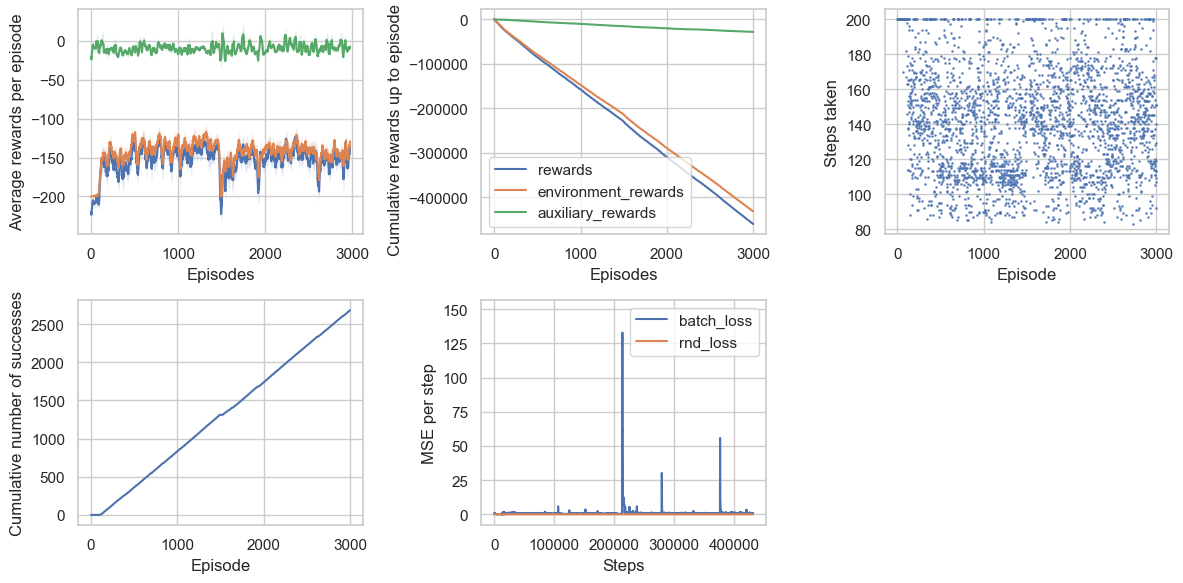

In [236]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

RND_rewards = {key: RND_training_stats[key] for key in reward_keys}
RND_losses = {key: RND_training_stats[key] for key in loss_keys}
plot_mean_reward_per_episode(RND_rewards, ax=ax[0][0])
plot_cumulative_rewards(RND_rewards, ax=ax[0][1])
plot_training_loss(RND_losses, ax=ax[1][1])
plot_success(RND_training_stats, ax=ax[1][0])
plot_episode_duration(RND_training_stats, ax=ax[0][2])
fig.delaxes(ax[1][2])
#legend = fig.legend(title='Reward factor', loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/DQNAgent_RND.png')


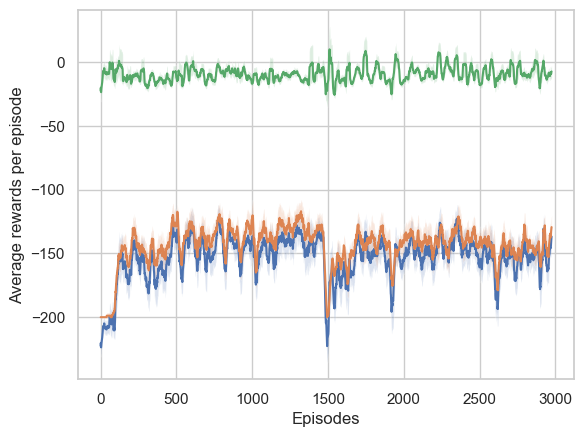

In [237]:
#plot auxiliary reward
plot_mean_reward_per_episode(RND_rewards)

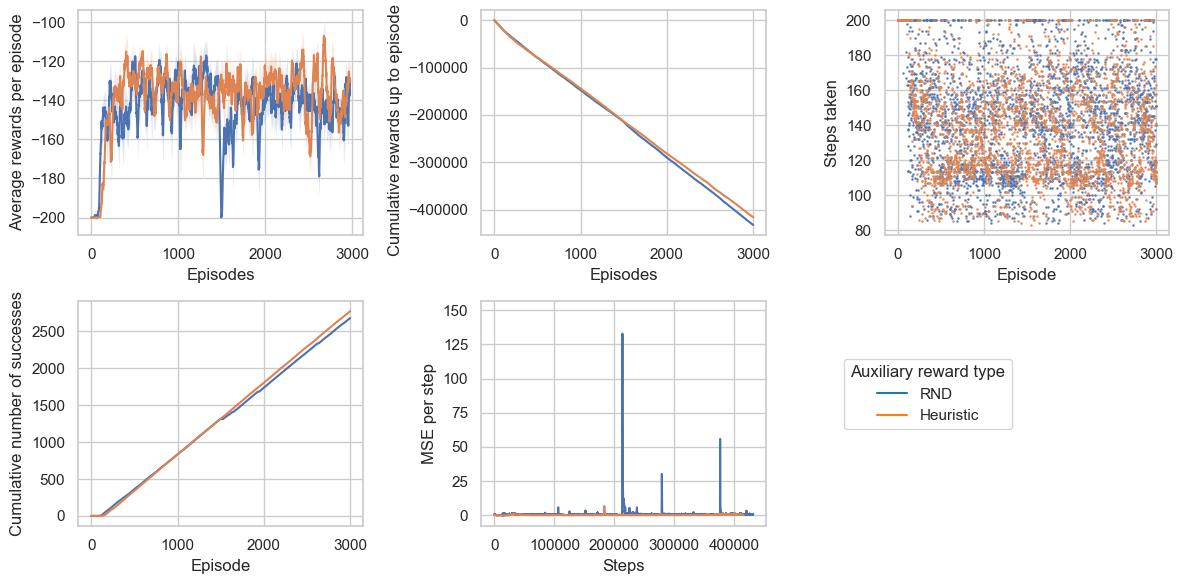

In [238]:
# compare RND to auxiliary
env_rewards_comp = {'episodes_environment_rewards RND': RND_training_stats['episodes_environment_rewards'],
                    'episodes_environment_rewards heuristic': heuristic_reward_dict['episodes_environment_rewards']}
losses_comp = {'training_batch_loss RND': RND_training_stats['training_rnd_loss'],
               'training_batch_loss heuristic': heuristic_loss_dict['training_batch_loss']}

env_rewards_RND = {'episodes_environment_rewards': RND_training_stats['episodes_environment_rewards']}
env_rewards_heuristic = {'episodes_environment_rewards': heuristic_training_stats['episodes_environment_rewards']}
losses_RND = {'training_batch_loss': RND_training_stats['training_batch_loss']}
losses_heuristic = {'training_batch_loss': heuristic_training_stats['training_batch_loss']}

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)

ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

plot_mean_reward_per_episode(env_rewards_RND, ax=ax[0][0])
plot_mean_reward_per_episode(env_rewards_heuristic, ax=ax[0][0])
plot_cumulative_rewards(env_rewards_RND, ax=ax[0][1])
plot_cumulative_rewards(env_rewards_heuristic, ax=ax[0][1])
plot_training_loss(losses_RND, ax=ax[1][1])
plot_training_loss(losses_heuristic, ax=ax[1][1])
plot_success(RND_training_stats, ax=ax[1][0])
plot_success(heuristic_training_stats, ax=ax[1][0])
plot_episode_duration(RND_training_stats, ax=ax[0][2])
plot_episode_duration(heuristic_training_stats, ax=ax[0][2])
fig.delaxes(ax[1][2])
# create legend
legend_handles = [plt.Line2D([0], [0], color=color_palette[0], label='RND'),
                  plt.Line2D([0], [0], color=color_palette[1], label='Heuristic')]
legend = fig.legend(handles=legend_handles, title='Auxiliary reward type', loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/RND_vs_auxiliary.png')
plt.show()

### DYNA part

In [239]:
# discretize the state space
class DYNAagent:
    def __init__(self, env, trainable: bool, gamma=0.99, discr_step=(0.025, 0.005), epsilon=0.9, epsilon_decay=1000,
                 epsilon_min=0.05, optimizer=optim.AdamW):
        # Initialize agent
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.trainable = trainable
        self.epsilon = epsilon  # exploration rate
        self.epsilon_decay = epsilon_decay  # decaying rate of epsilon
        self.epsilon_min = epsilon_min  # minimum value of epsilon
        self.gamma = gamma  # discount factor
        self.loss = nn.MSELoss()  # loss function

        self.space = [np.arange(-1.2, 0.6+discr_step[i], discr_step[i]) for i in range(2)]

        # discretize space

    def discretize_state(self, state):
        # return bin number for each state dimension as discretized state
        return np.digitize(state, self.space)


    
#create agent
dyn_agent = DYNAagent(env, trainable=True)
dyn_agent.discretize_state(env.reset())




ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

: 